In [1]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pyvista as pv
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
def load_data_test(h5_file_path, batch_size):
    with h5py.File(h5_file_path, 'r') as hf:
        X = hf['X']
        Y = hf['Y']
        num_samples = X.shape[0]
        test_samples=int(num_samples*0.2)

        while True:  
            for i in range(0, test_samples, batch_size):
                X_batch = X[i:i + batch_size]
                Y_batch = Y[i:i + batch_size]
                yield X_batch, Y_batch

In [3]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Flatten the tensors
    y_true=tf.cast(y_true,tf.float32)
    y_pred=tf.cast(y_pred,tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    # Calculate Dice coefficient
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice

In [4]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    # Flatten the tensors
    y_true=tf.cast(y_true,tf.float32)
    y_pred=tf.cast(y_pred,tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    
    # Calculate IoU
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [5]:
model=keras.models.load_model('final_model2.keras',custom_objects={
    'dice_coefficient': dice_coefficient,
    'iou_metric': iou_metric
})

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


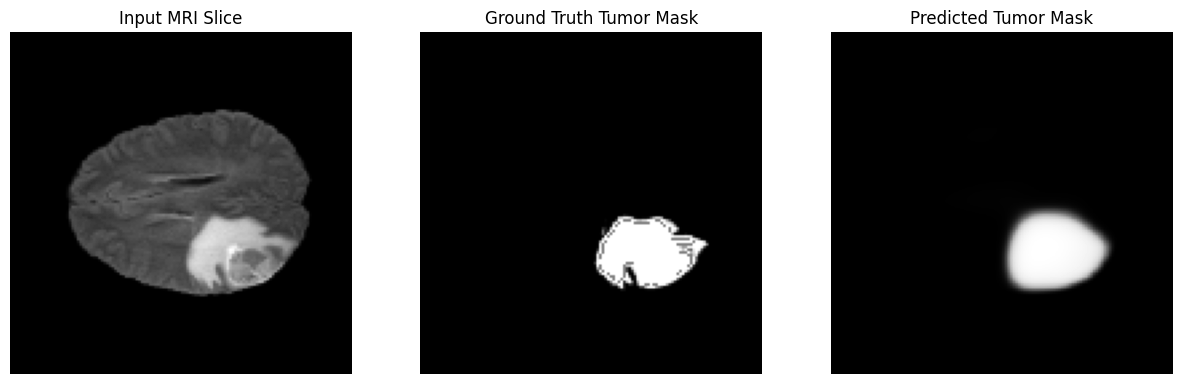

In [6]:
file_path = 'brain_tumor_data4.h5'  
with h5py.File(file_path, 'r') as f:
    input_data = f['X'][:]    
    ground_truth = f['Y'][:]  
    predicted_output = model.predict(input_data[:4])
slice_index = 15
input_slice = input_data[3, :, :, slice_index, 0]       
ground_truth_slice = ground_truth[3, :, :, slice_index]
predicted_slice = predicted_output[3, :, :, slice_index]
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(input_slice, cmap='gray')
plt.title('Input MRI Slice')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_slice, cmap='gray')
plt.title('Ground Truth Tumor Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_slice, cmap='gray')
plt.title('Predicted Tumor Mask')
plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Reconstruction Loss (MSE) on Test Set: 0.0060


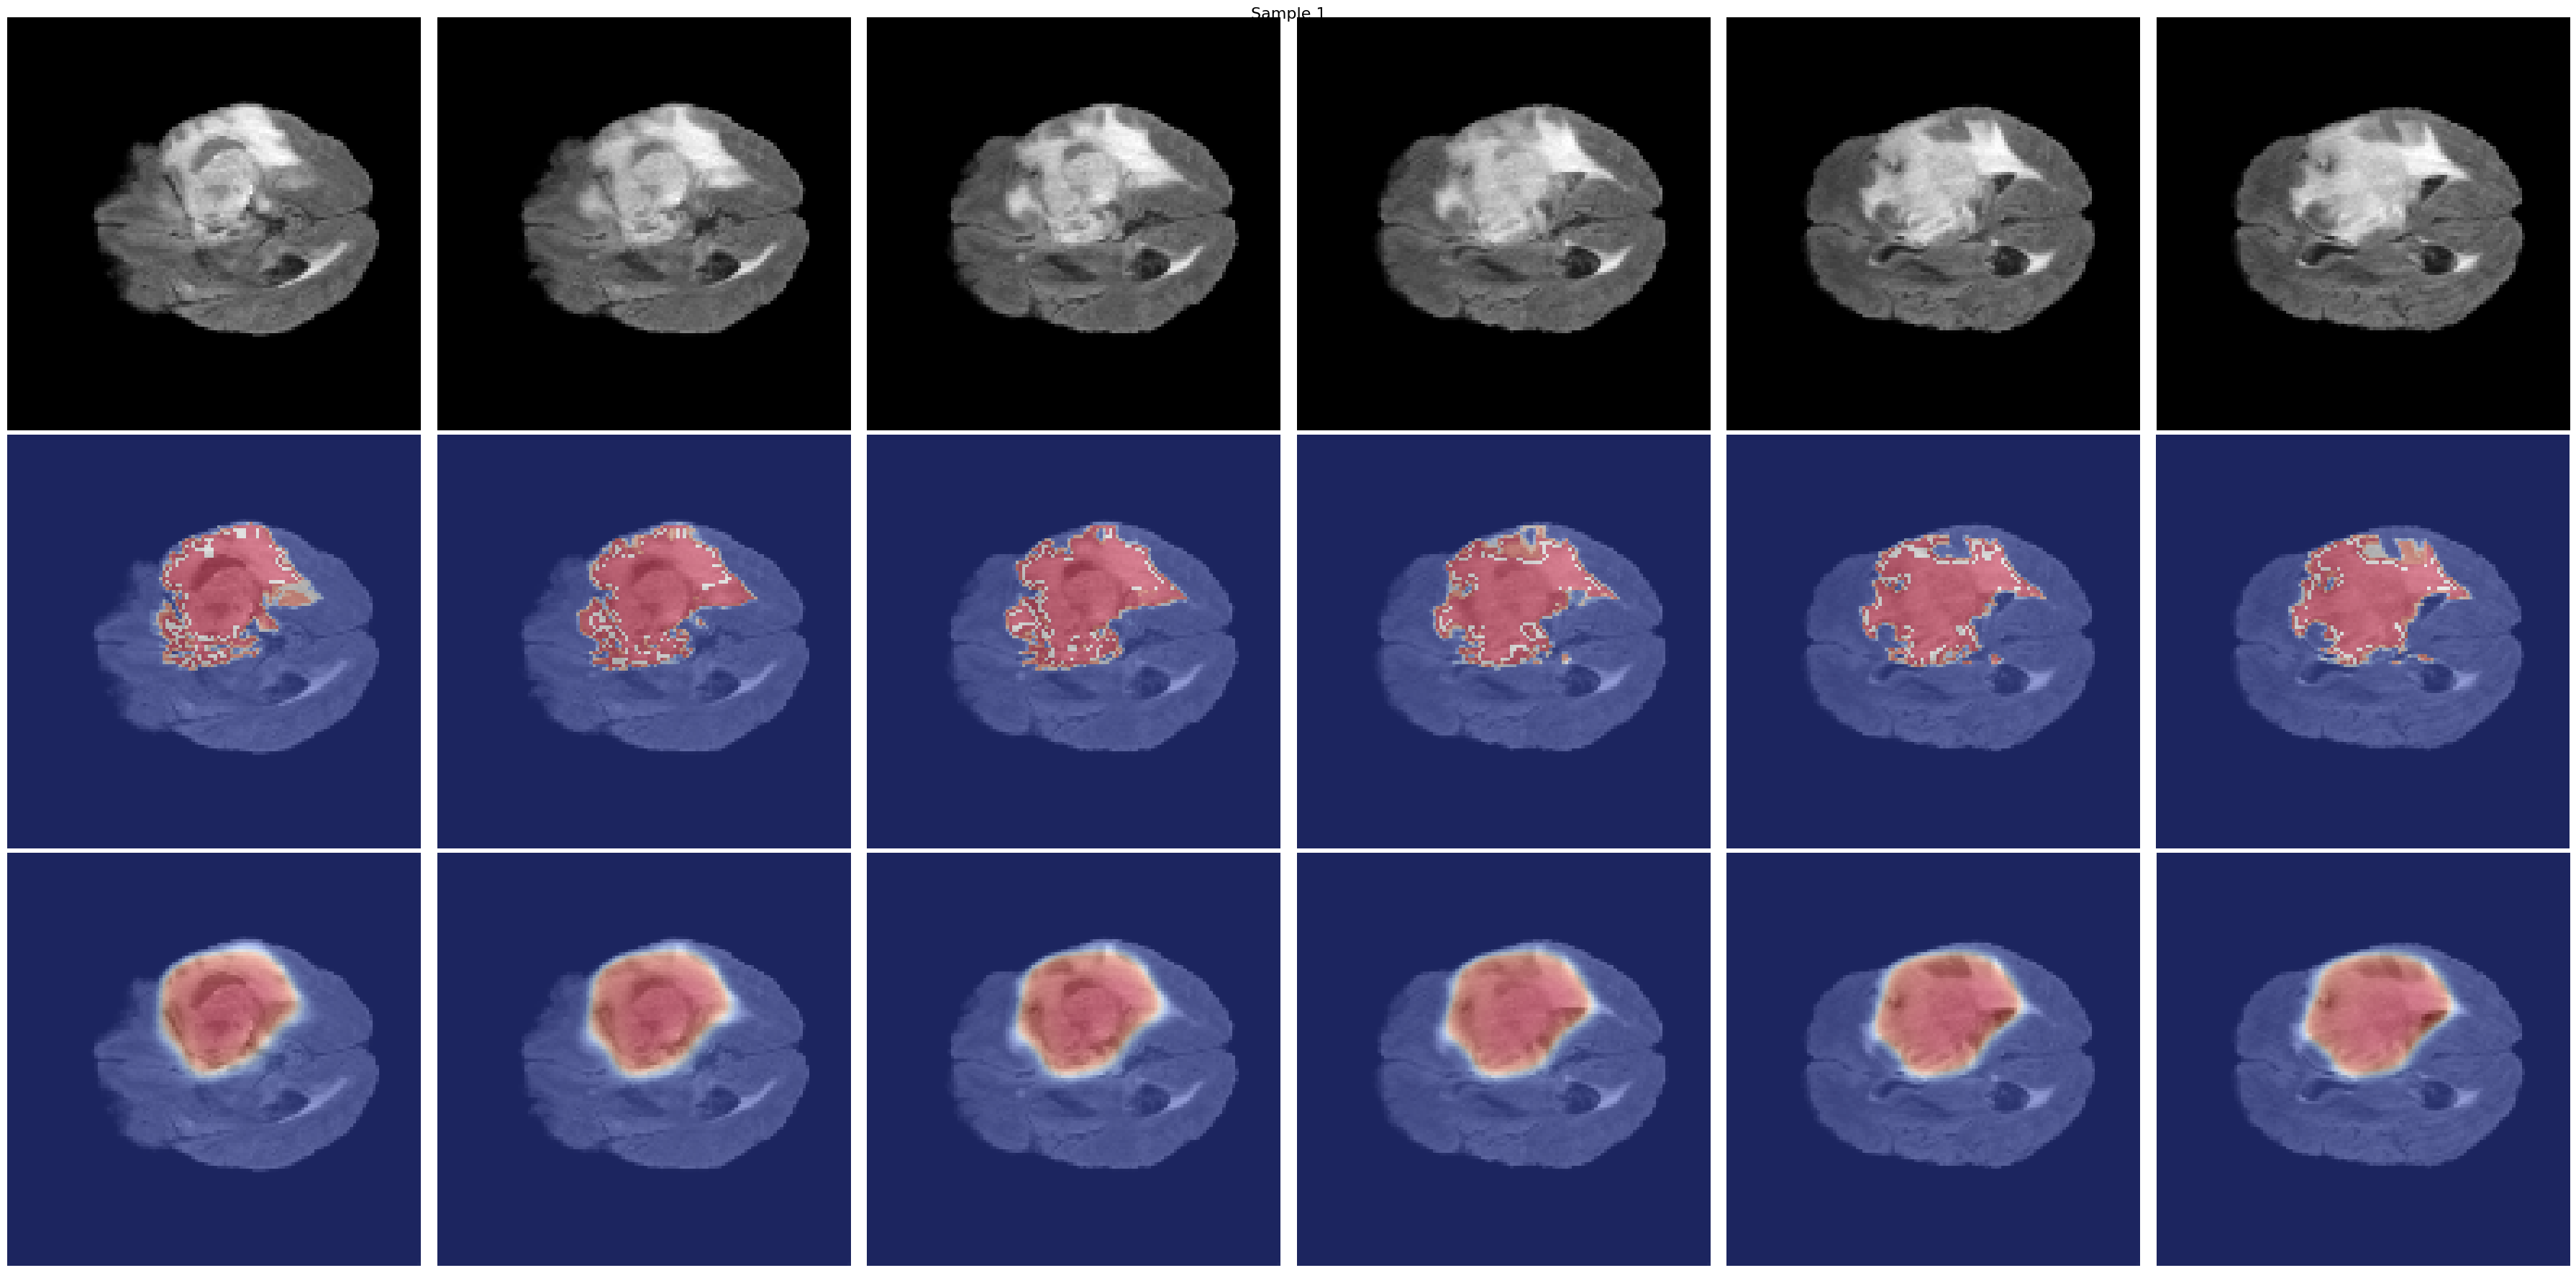

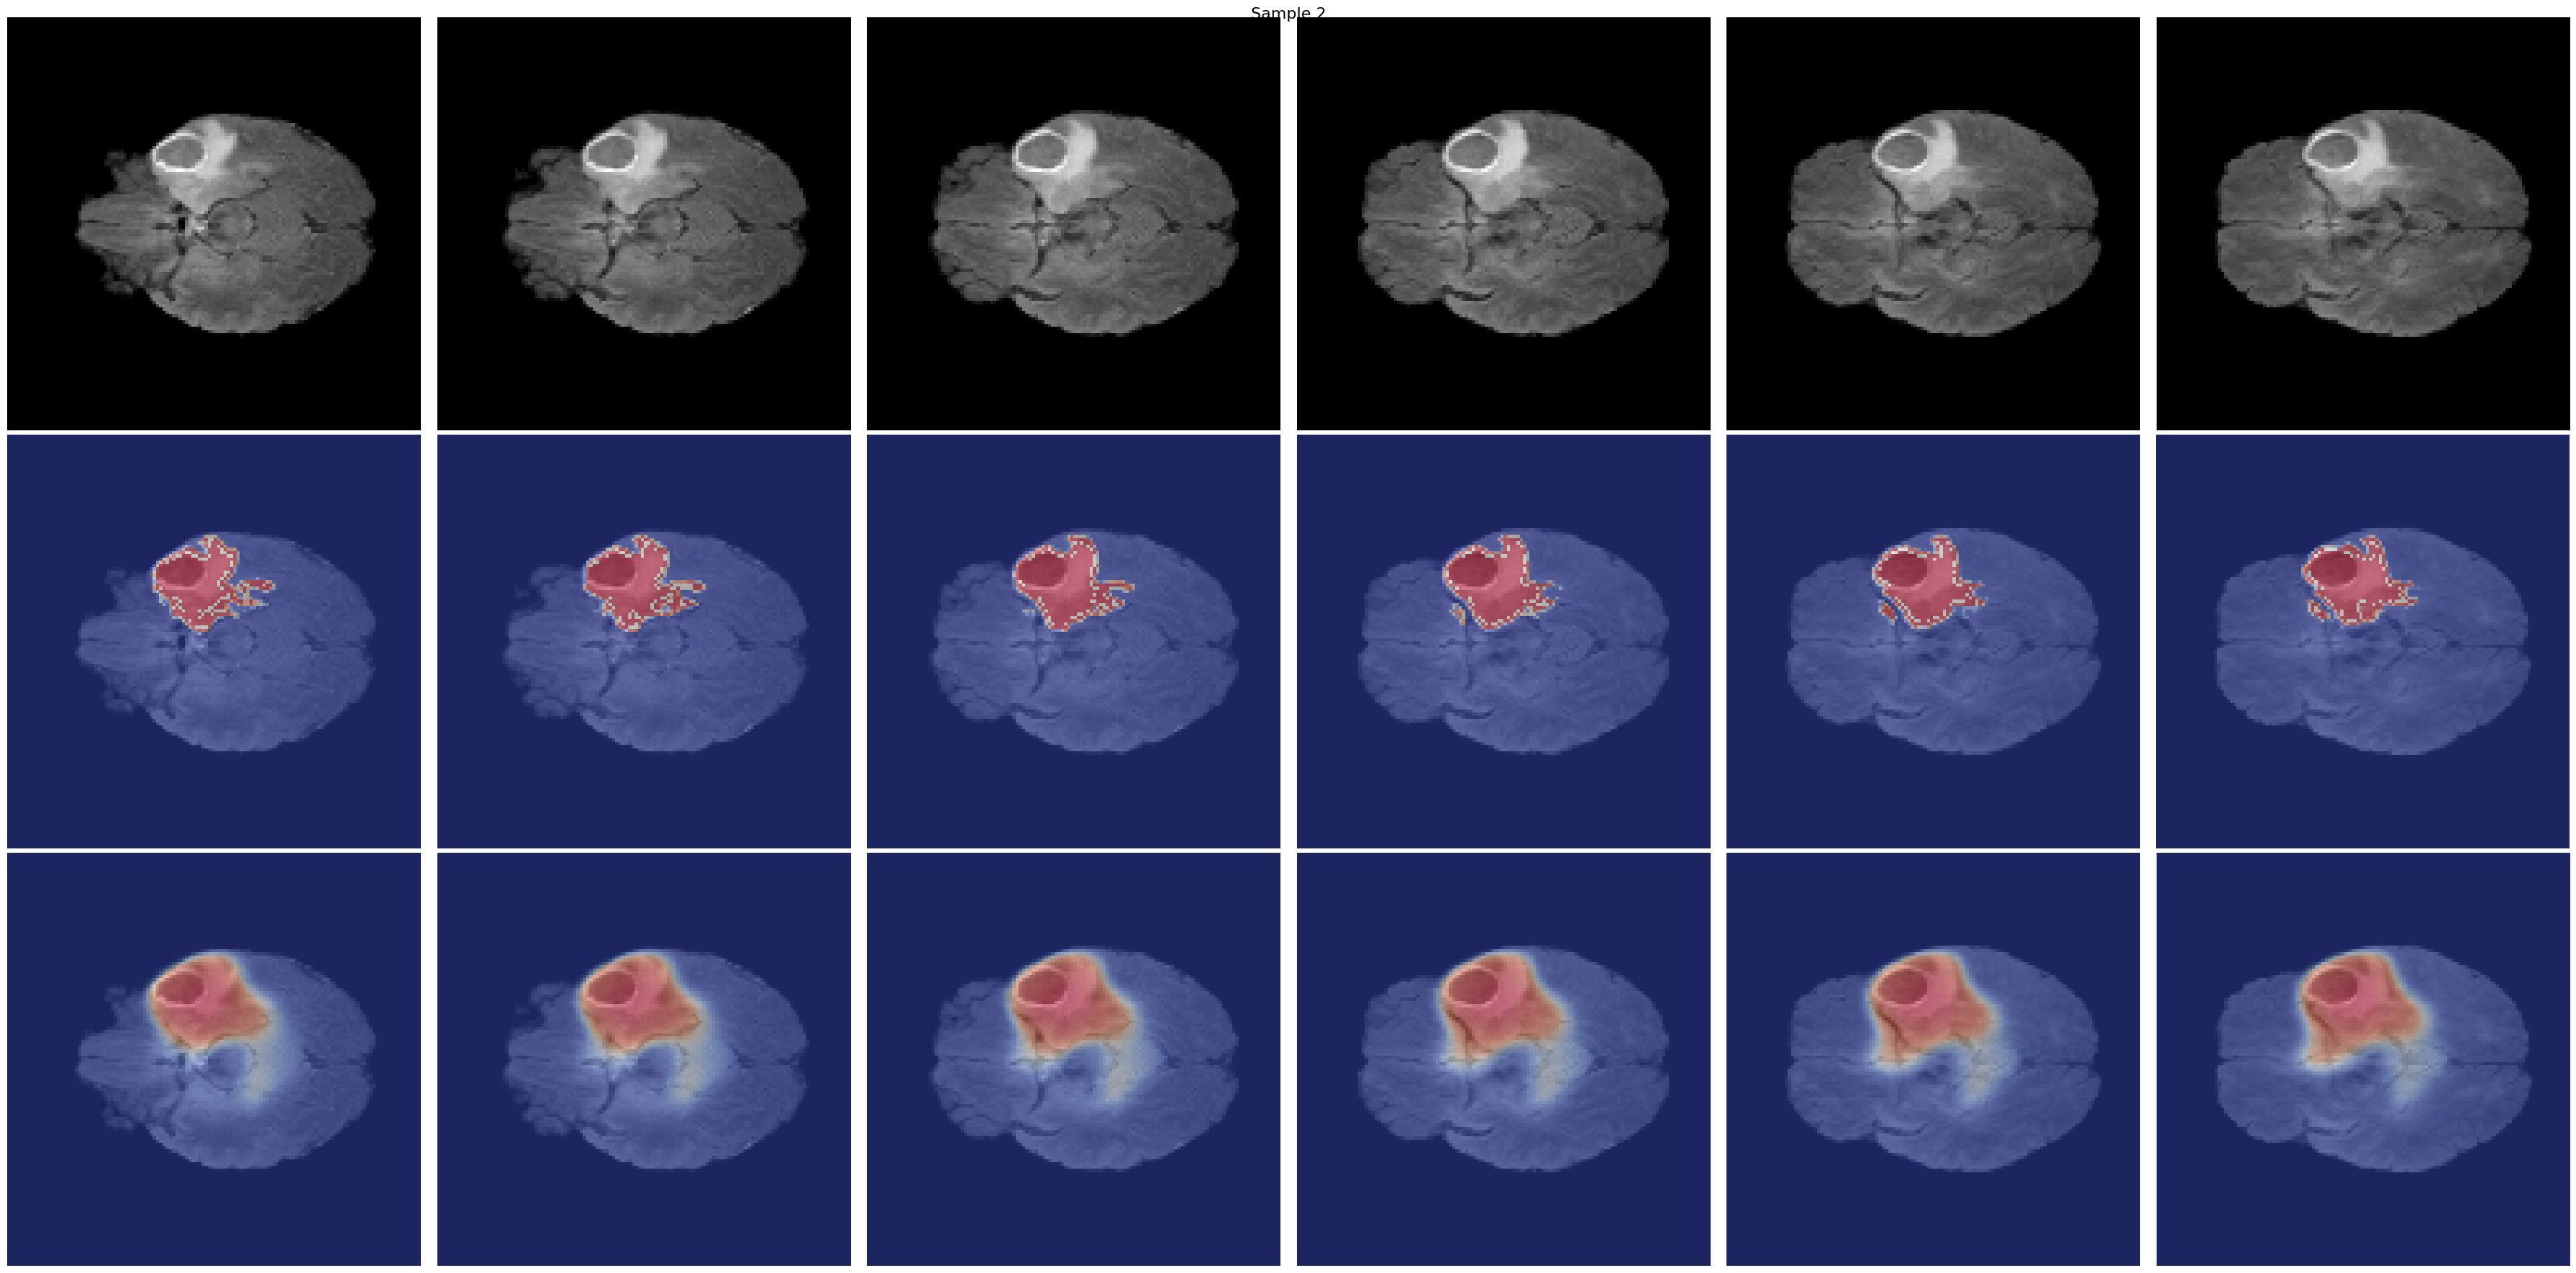

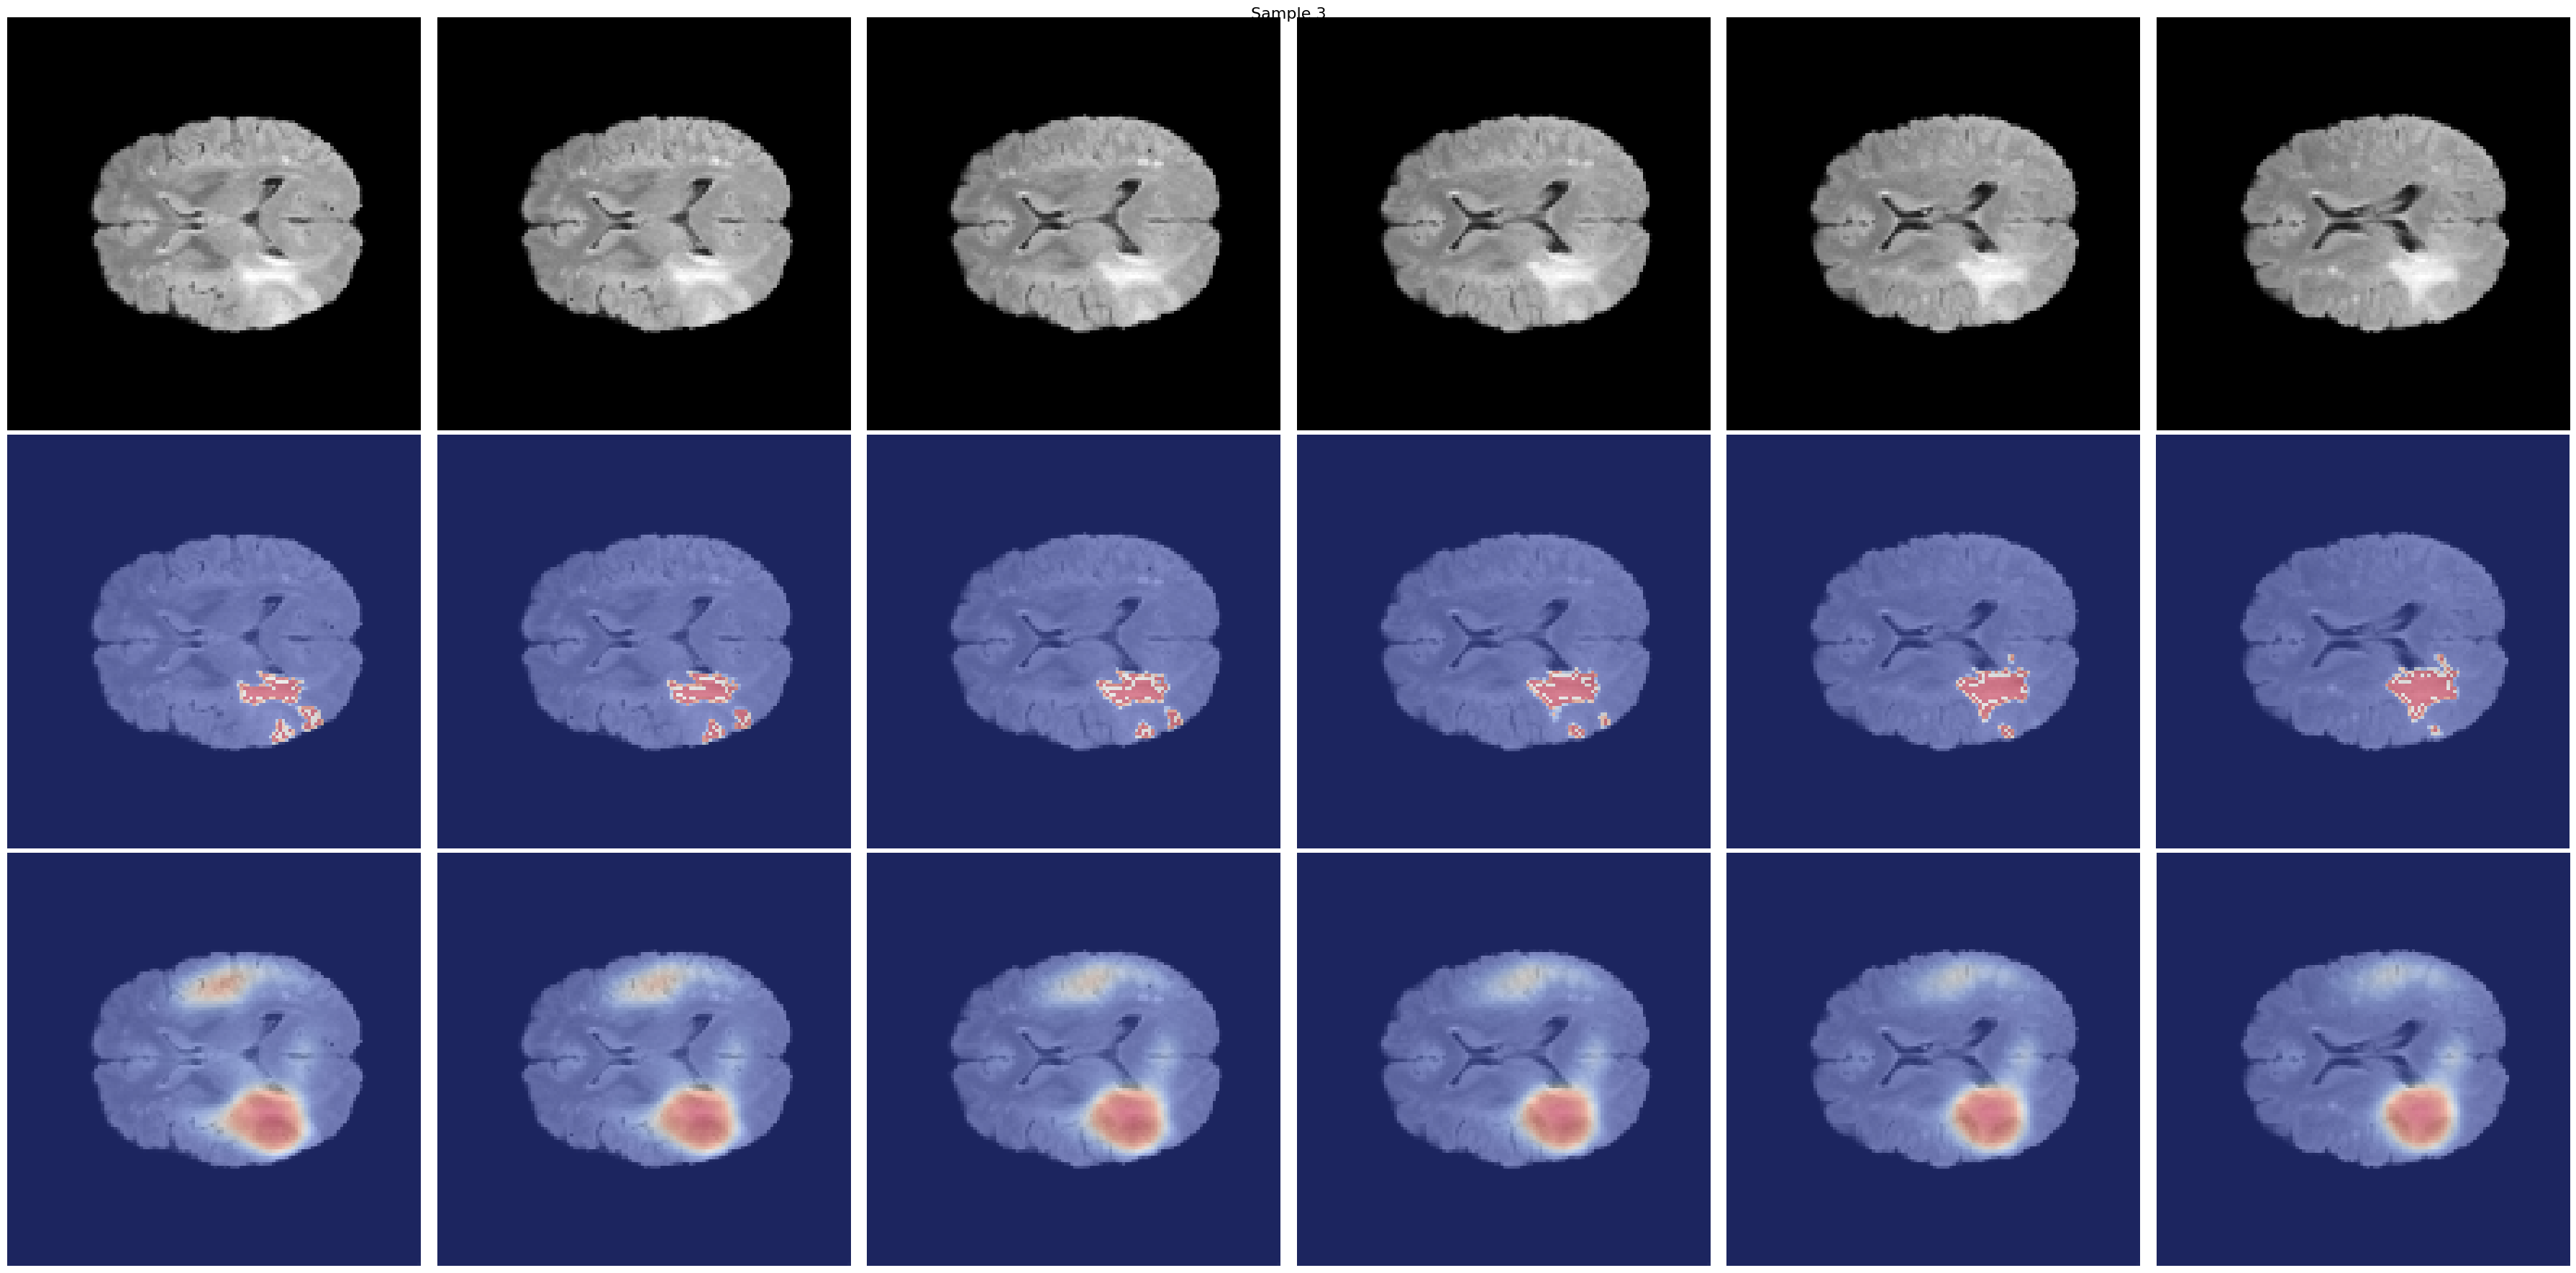

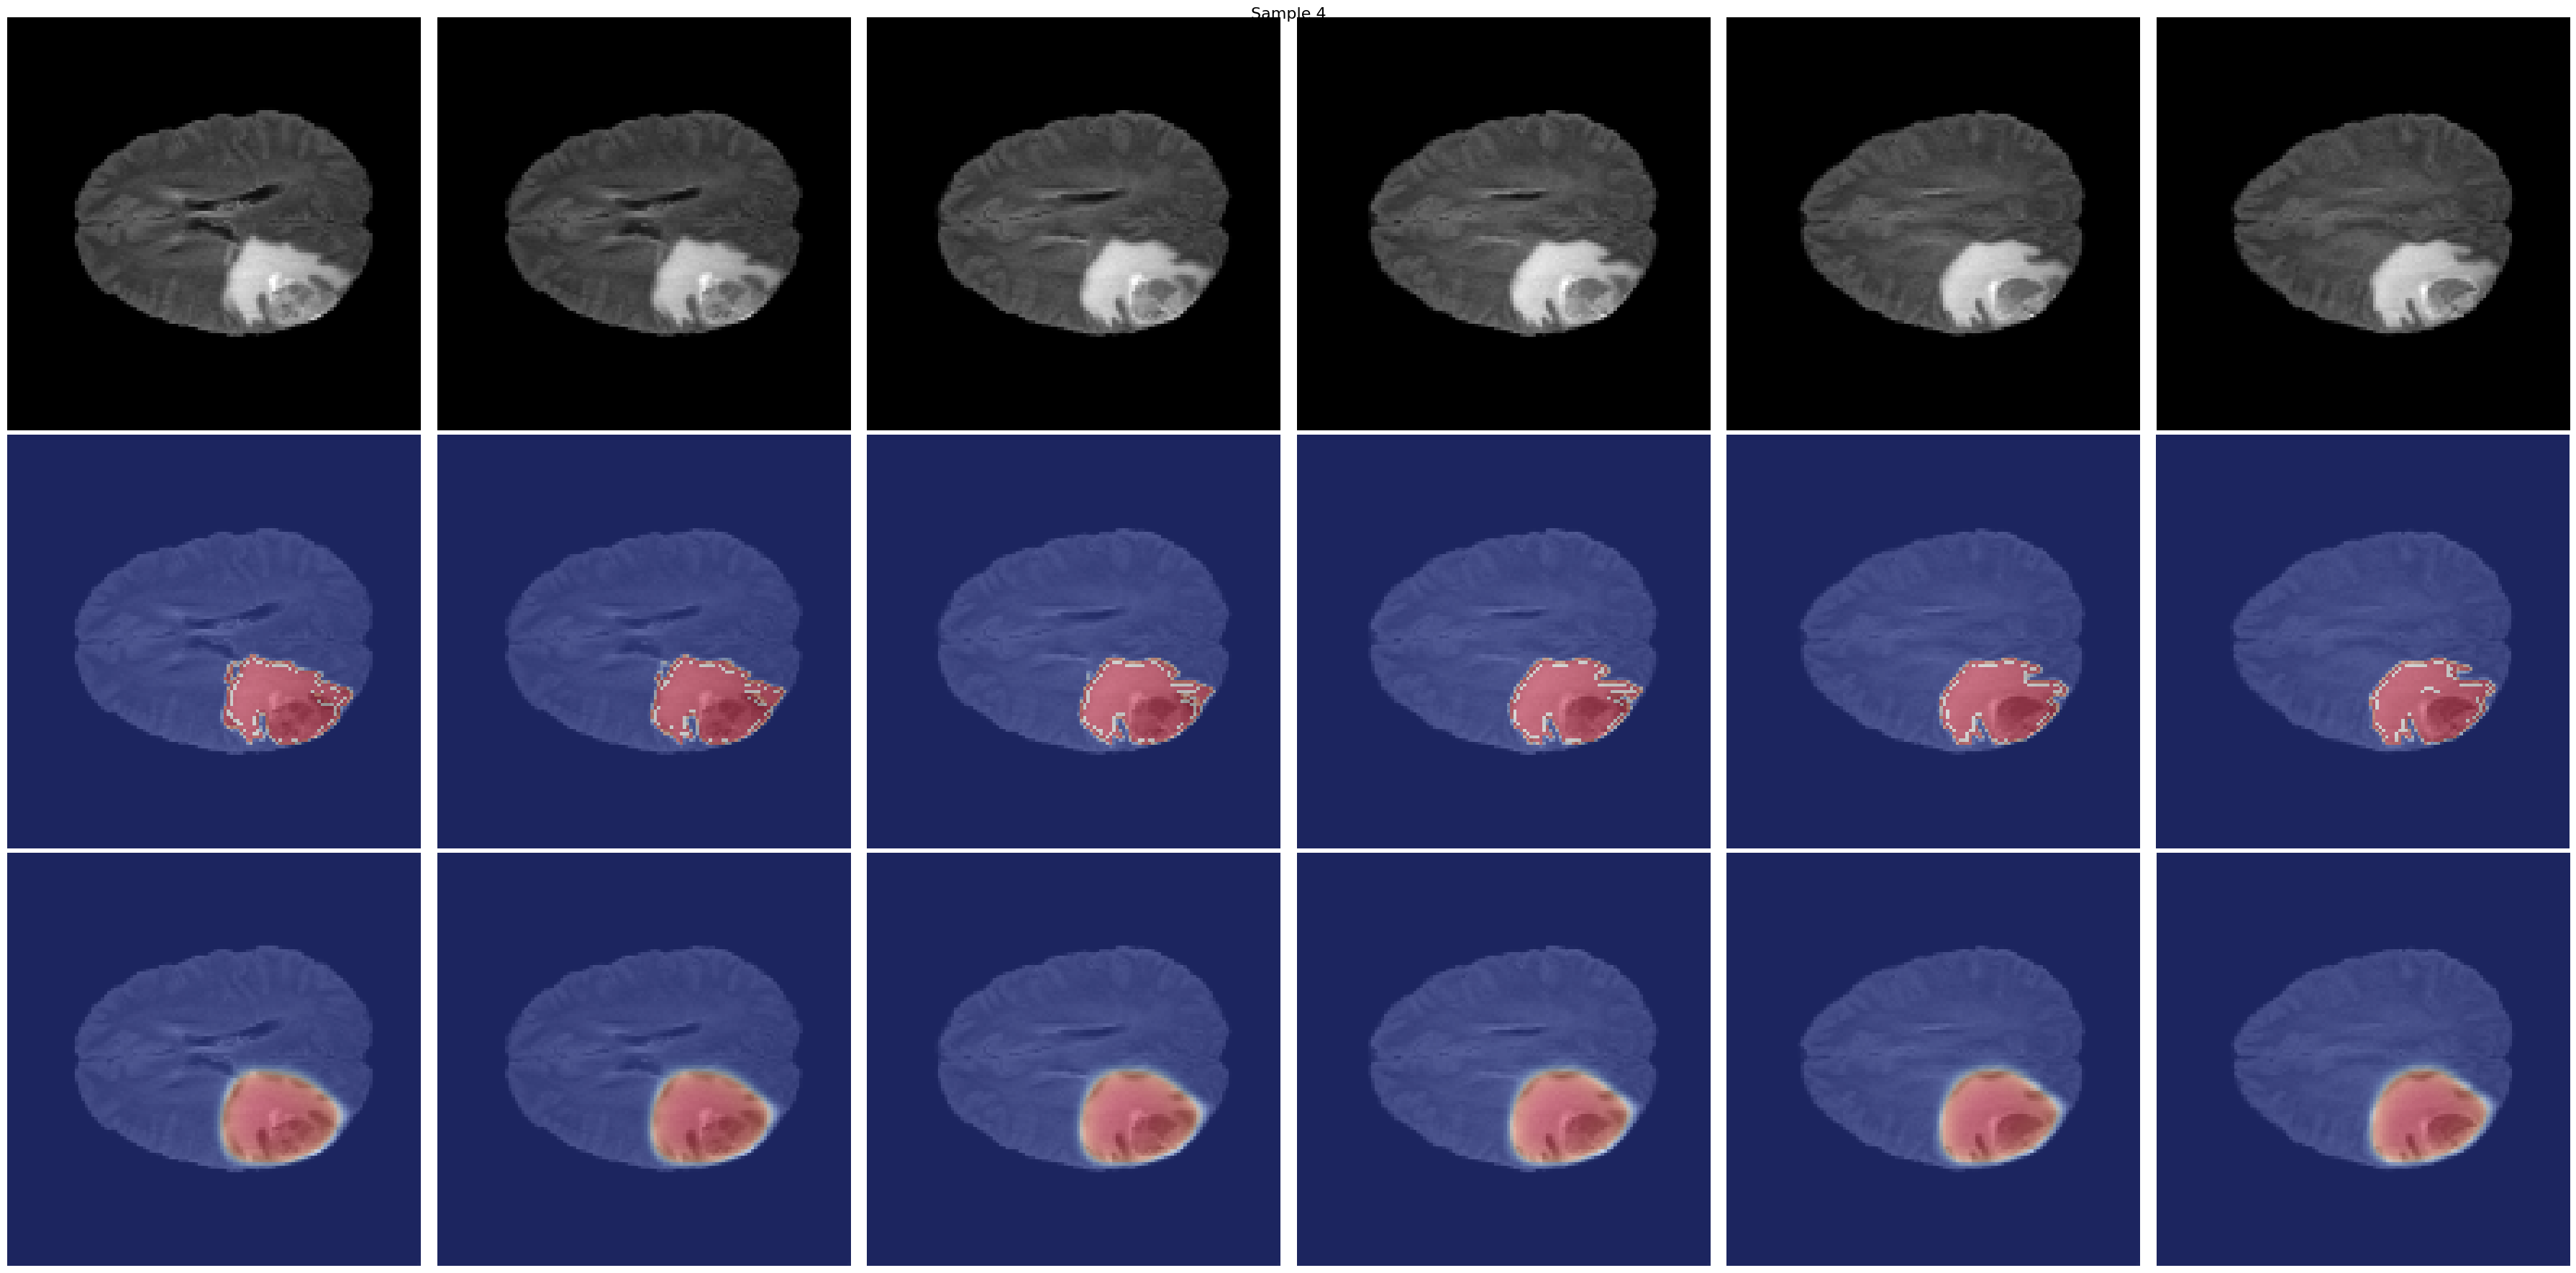

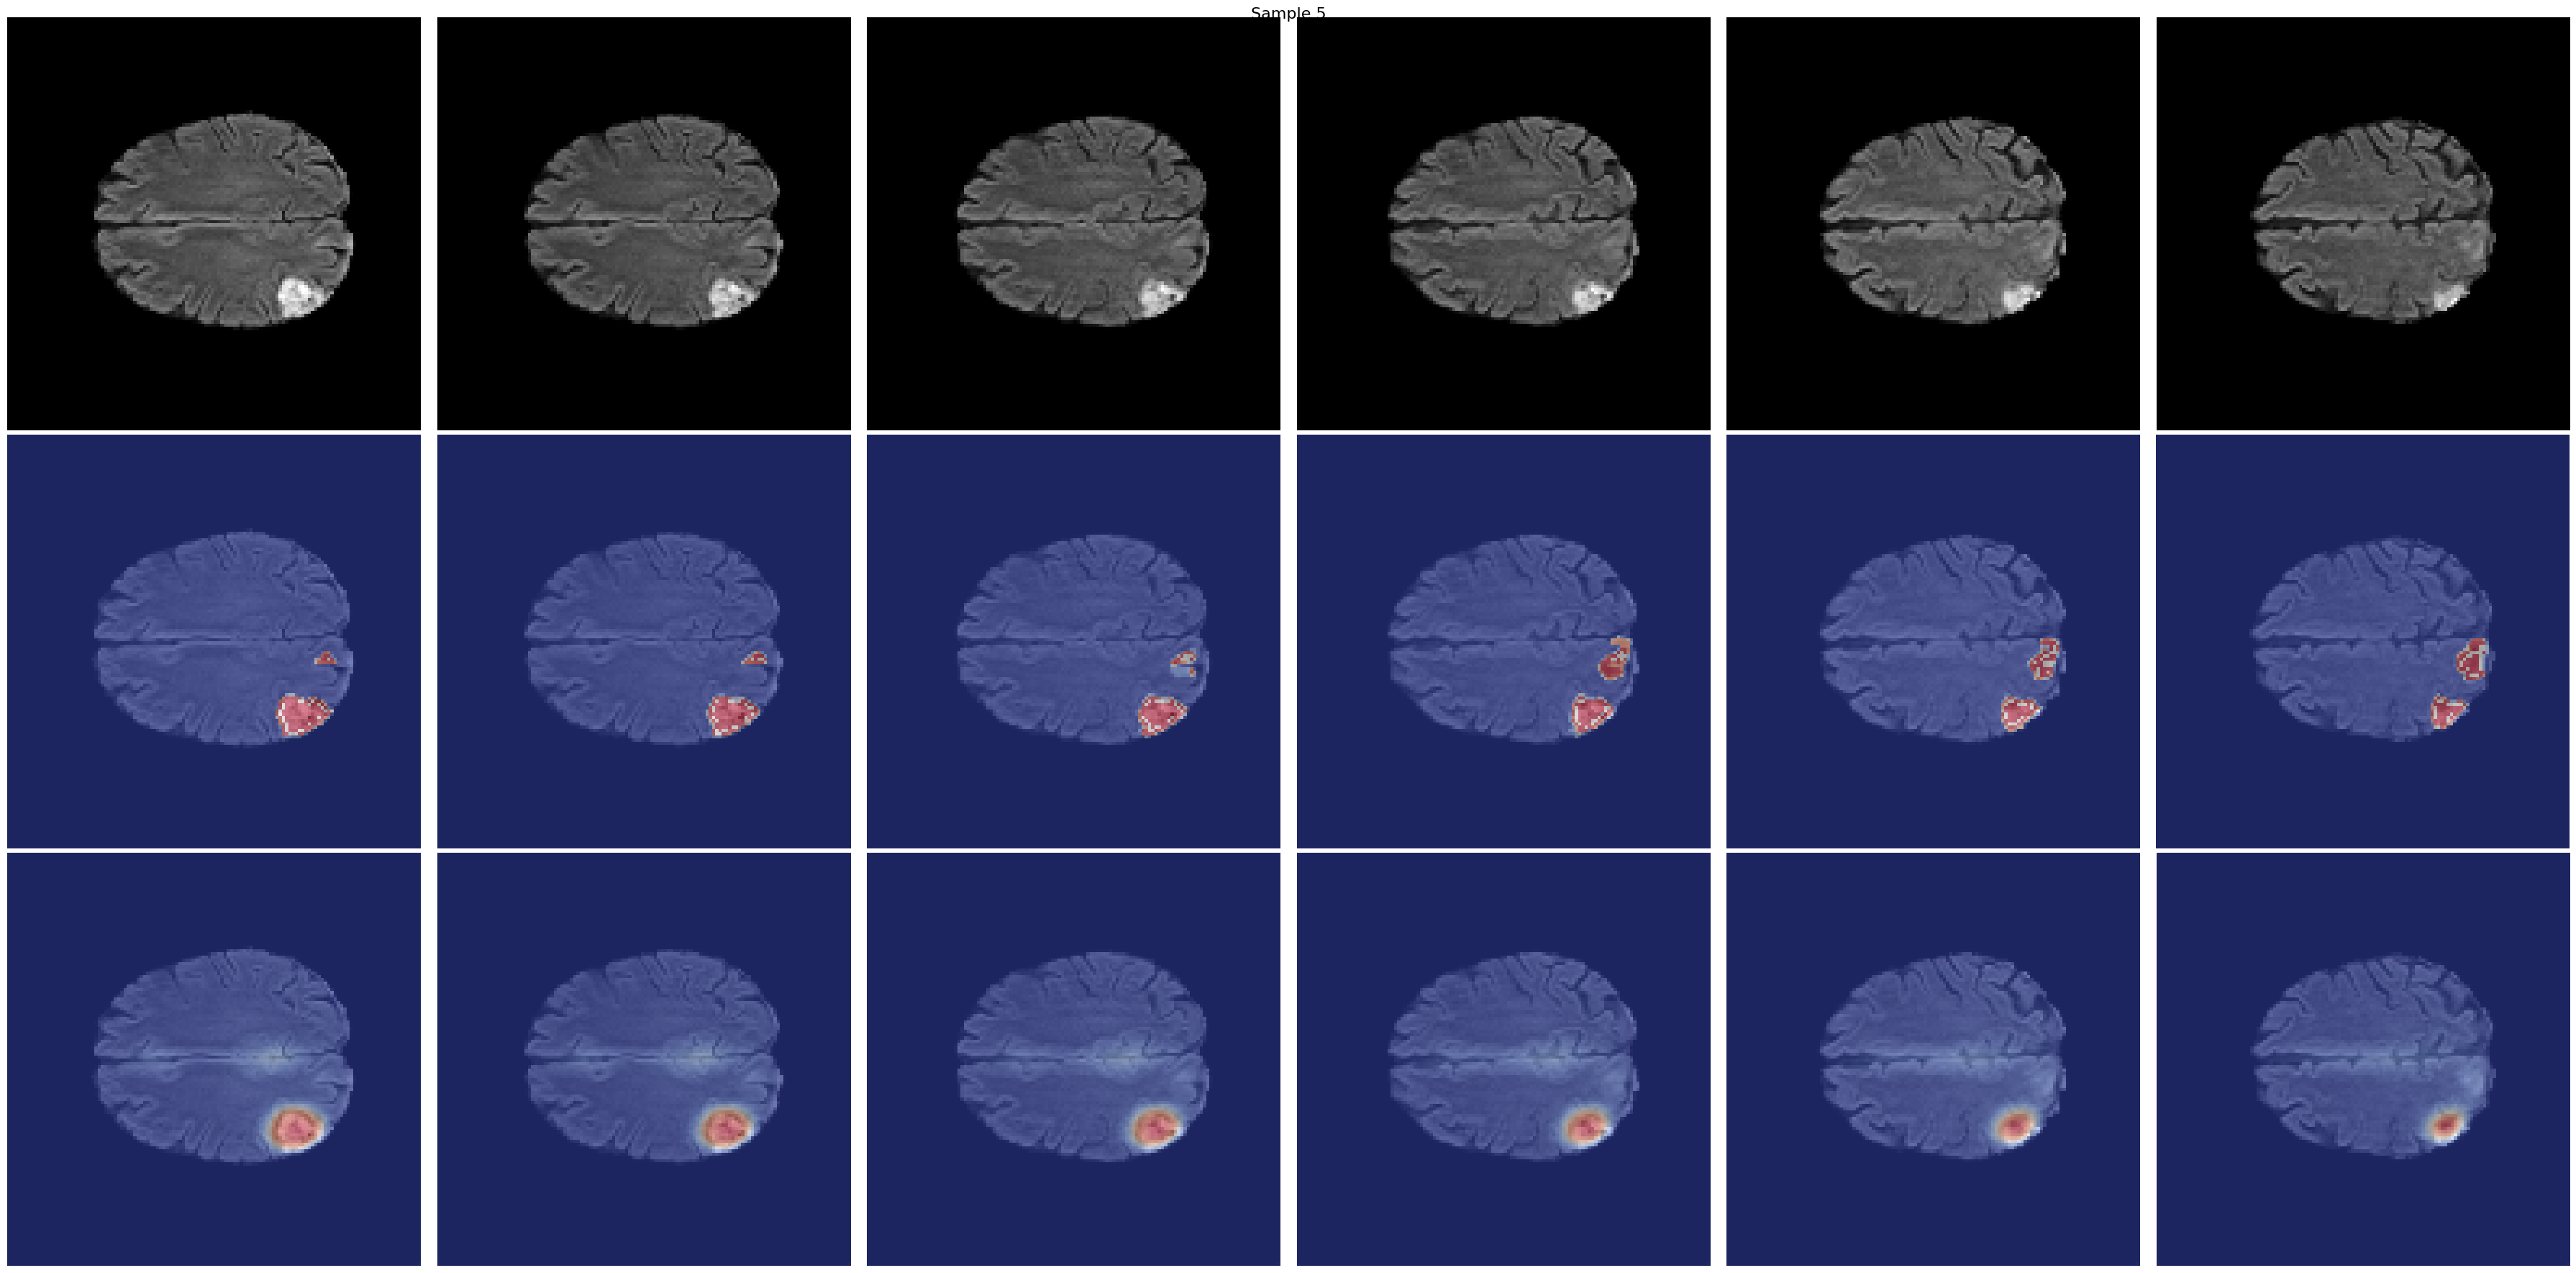

In [7]:
def evaluate_autoencoder(model, h5_file_path, batch_size, num_samples_to_visualize=5):
    # Load test data
    test_data_gen = load_data_test(h5_file_path, batch_size)
    
    # Get a single batch for evaluation
    X_test, Y_test = next(test_data_gen)
    X_test = X_test.astype('float32')
    Y_test = Y_test.astype('float32')
    # Predict using the autoencoder
    reconstructed = model.predict(X_test, batch_size=batch_size)

    # Calculate reconstruction loss (MSE)
    reconstruction_loss = np.mean(np.square(Y_test - reconstructed[:,:,:,:,0]))
    print(f"Reconstruction Loss (MSE) on Test Set: {reconstruction_loss:.4f}")

    # Visualize a few samples from the test set and their reconstructions
    for i in range(num_samples_to_visualize):
        visualize_3d_volume(X_test[i],Y_test[i], reconstructed[i], f"Sample {i+1}")

def visualize_3d_volume(original, actual, reconstructed, title, image_size=(6, 6)):
    num_slices = 6  # Number of slices along the z-axis
    fig, axes = plt.subplots(3, num_slices, figsize=(num_slices * image_size[0], 3 * image_size[1]))
    fig.suptitle(title, fontsize=16)
    for i in range((original.shape[2]-num_slices)//2,(original.shape[2]+num_slices)//2):  # Iterate over slices along the z-axis
        # Original Image
        ax = axes[ 0,i-(original.shape[2]-num_slices)//2]
        ax.imshow(original[:, :, i, 0], cmap="gray")
        ax.axis("off")
        if i == 0:
            ax.set_title("Original")

        # Ground Truth
        ax = axes[1 ,i-(original.shape[2]-num_slices)//2]
        ax.imshow(original[:, :, i, 0], cmap="gray")
        ax.imshow(actual[:, :, i], cmap="coolwarm", alpha=0.5)
        ax.axis("off")
        if i == 0:
            ax.set_title("Ground Truth")

        # Prediction
        ax = axes[2, i-(original.shape[2]-num_slices)//2]
        ax.imshow(original[:, :, i, 0], cmap="gray")
        ax.imshow(reconstructed[:, :, i, 0], cmap="coolwarm", alpha=0.5)
        ax.axis("off")
        if i == 0:
            ax.set_title("Prediction")
    plt.tight_layout()
    plt.show()
h5_file_path = "brain_tumor_data4.h5"  # Replace with your HDF5 file path
batch_size = 8  # Adjust based on your GPU/CPU memory capacity
evaluate_autoencoder(model, h5_file_path, batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Unique values in Y_test (before thresholding): [0.000e+00 5.960e-08 1.192e-07 ... 9.990e-01 9.995e-01 1.000e+00]
Unique values in Y_pred (before thresholding): [1.2841188e-22 1.3494308e-22 1.3586765e-22 ... 9.7865409e-01 9.7865719e-01
 9.7867090e-01]
Unique values in Y_true_flat: [0 1]
Unique values in Y_pred_flat: [0 1]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99   4118650
           1       0.64      0.81      0.72     75654

    accuracy                           0.99   4194304
   macro avg       0.82      0.90      0.86   4194304
weighted avg       0.99      0.99      0.99   4194304



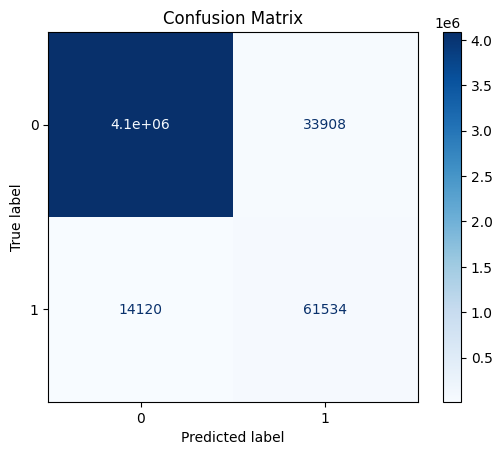

In [8]:
def evaluate_model_on_test_set(model, h5_file_path, batch_size):
    # Load a batch of test data
    test_gen = load_data_test(h5_file_path, batch_size)
    X_test, Y_test = next(test_gen)
    
    # Predict the outputs
    Y_pred = model.predict(X_test, batch_size=batch_size)
    
    # Debugging: Check unique values in Y_test and Y_pred
    print("Unique values in Y_test (before thresholding):", np.unique(Y_test))
    print("Unique values in Y_pred (before thresholding):", np.unique(Y_pred))
    
    # Threshold predictions to binary values
    Y_pred_binary = (Y_pred > 0.5).astype('int32')
    
    # Ensure Y_test is binary
    Y_test_binary = (Y_test > 0.5).astype('int32')  # In case Y_test contains continuous values
    
    # Flatten the arrays
    Y_true_flat = Y_test_binary.flatten()
    Y_pred_flat = Y_pred_binary.flatten()
    
    # Debugging: Check unique values in flattened arrays
    print("Unique values in Y_true_flat:", np.unique(Y_true_flat))
    print("Unique values in Y_pred_flat:", np.unique(Y_pred_flat))
    
    # Ensure valid binary inputs
    assert np.array_equal(np.unique(Y_true_flat), [0, 1]), "Y_test contains non-binary values."
    assert np.array_equal(np.unique(Y_pred_flat), [0, 1]) or np.array_equal(np.unique(Y_pred_flat), [0]), "Y_pred contains non-binary values."
    
    # Classification report
    print("Classification Report:")
    print(classification_report(Y_true_flat, Y_pred_flat))
    
    # Confusion matrix
    cm = confusion_matrix(Y_true_flat, Y_pred_flat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

# Call the evaluation function
evaluate_model_on_test_set(model, h5_file_path, batch_size)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


c:\Users\VANSH GARG\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\core\utilities\points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(
c:\Users\VANSH GARG\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\VANSH GARG\AppData\Local\Programs\Python\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


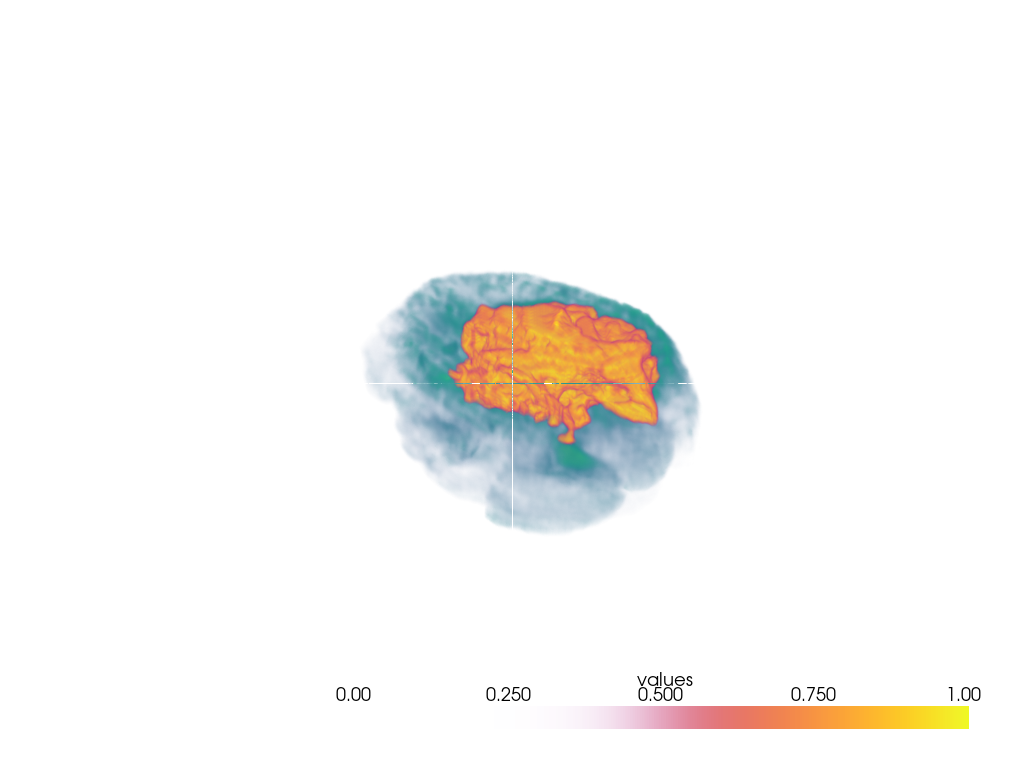

c:\Users\VANSH GARG\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (c:\Users\VANSH GARG\AppData\Local\Programs\Python\Python312\Lib\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


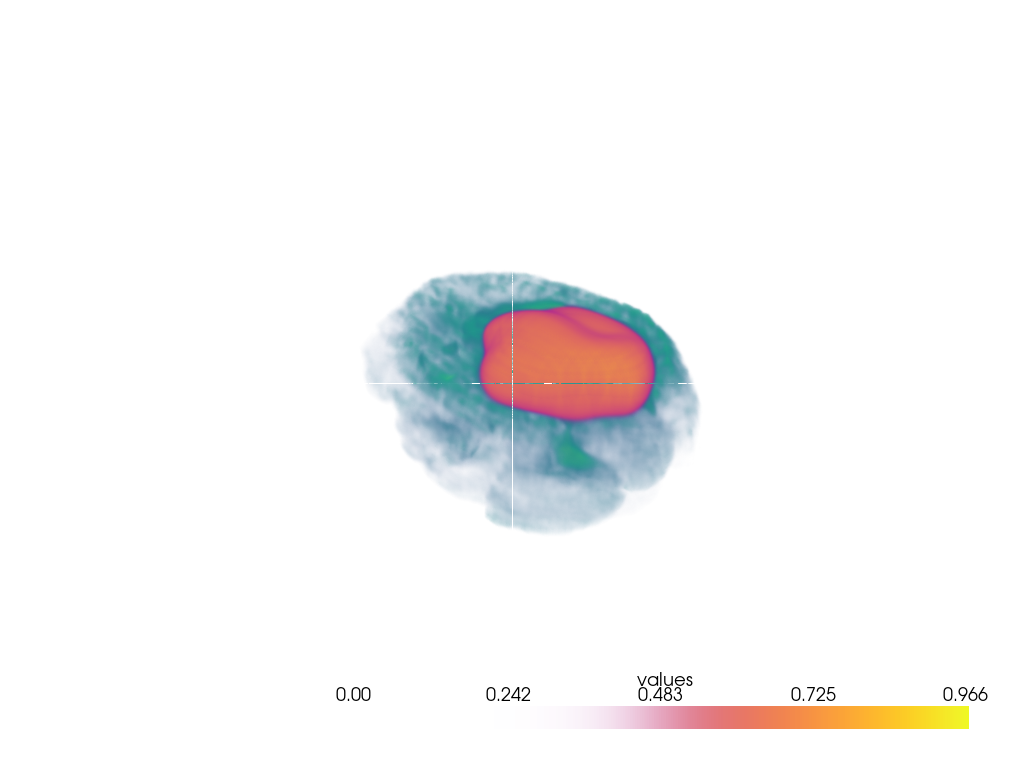

In [9]:
test_data_gen= load_data_test('brain_tumor_data4.h5',batch_size)
X_test,Y_test=next(test_data_gen)
Y_pred=model.predict(X_test)
data=X_test[0]
data_true=Y_test[0]
data_pred=Y_pred[0]
x, y, z = np.meshgrid(
    np.arange(data.shape[0]),
    np.arange(data.shape[1]),
    np.arange(data.shape[2]),
    indexing='ij'
)
x_t, y_t, z_t = np.meshgrid(
    np.arange(data_true.shape[0]),
    np.arange(data_true.shape[1]),
    np.arange(data_true.shape[2]),
    indexing='ij'
)
x_p, y_p, z_p = np.meshgrid(
    np.arange(data_pred.shape[0]),
    np.arange(data_pred.shape[1]),
    np.arange(data_pred.shape[2]),
    indexing='ij'
)
data=data[:,:,:,0]
data=data.astype('float32')
data_true=data_true.astype('float32')
data_pred=data_pred[:,:,:,0]
data_pred=data_pred.astype('float32')
# Create PyVista StructuredGrid
grid = pv.StructuredGrid(x, y, z)
grid_t = pv.StructuredGrid(x_t, y_t, z_t)
grid_p = pv.StructuredGrid(x_p, y_p, z_p)
# Add data to the grid as point data
grid.point_data["values"] = data.flatten(order="F")
grid_t.point_data["values"] = data_true.flatten(order="F")
grid_p.point_data["values"] = data_pred.flatten(order="F")
# Plot the volume
plotter = pv.Plotter()
plotter.add_volume(grid, scalars="values", cmap="viridis", opacity="sigmoid")
plotter.add_volume(grid_t, scalars="values", cmap="plasma", opacity="sigmoid")
plotter.show()

plotter_pred=pv.Plotter()
plotter_pred.add_volume(grid, scalars="values", cmap="viridis", opacity="sigmoid")
plotter_pred.add_volume(grid_p, scalars="values", cmap="plasma", opacity="sigmoid")
plotter_pred.show()